# CS4287 Assignment 2
## YR 4 SEM 1 2023
Kim O'Regan: 20277628

Imelda Butler: 20259344

Can the code execute to the end without error? Y/N

In [1]:
import datetime
import shutil
from pathlib import Path
from collections import Counter

import yaml
import numpy as np
import pandas as pd
from ultralytics import YOLO
from sklearn.model_selection import KFold

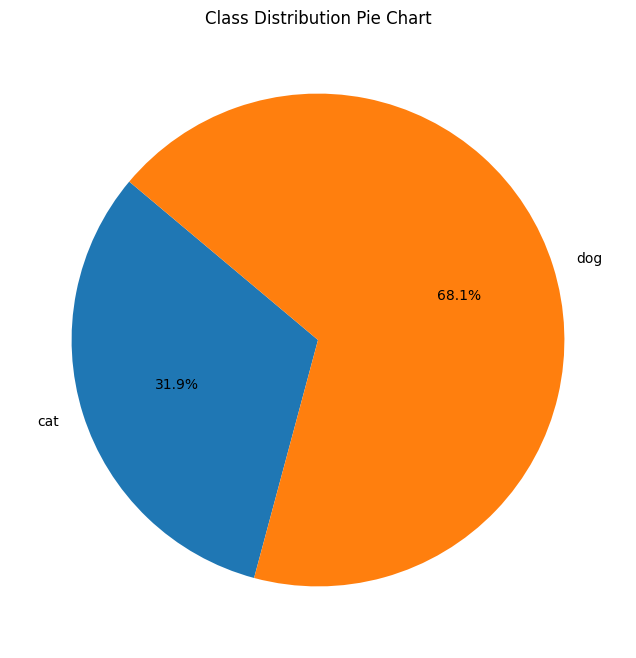

In [2]:
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# Path to the directory containing YOLO annotation files
annotation_dir = "train\labels"  

# Extract class labels from annotation files
class_labels = []

for filename in os.listdir(annotation_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(annotation_dir, filename), 'r') as file:
            # Assuming the class label is the first value in each annotation file
            line = file.readline().strip().split()
            if line:
                class_label = int(line[0])
                class_labels.append(class_label)

# Map class labels to class names
class_names = ['cat', 'dog']
class_labels = [class_names[label] for label in class_labels]

# Calculate class distribution
class_distribution = Counter(class_labels)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_distribution.values(), labels=class_distribution.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Pie Chart')
plt.show()

In [3]:
# In this cell, we will investigate differing hyperparameters for a small batch size.
# Load model
model = YOLO("yolov8n.yaml")



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
# Hyperparameter search
epochs_list = [10, 50, 75, 100]
results_dict = {}

for epochs in epochs_list:
    # Training the model. We don't actually need the imgsz, but better safe than sorry
    results = model.train(data="data.yaml", epochs=epochs, imgsz=64, batch=32)
    results_dict[epochs] = results

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


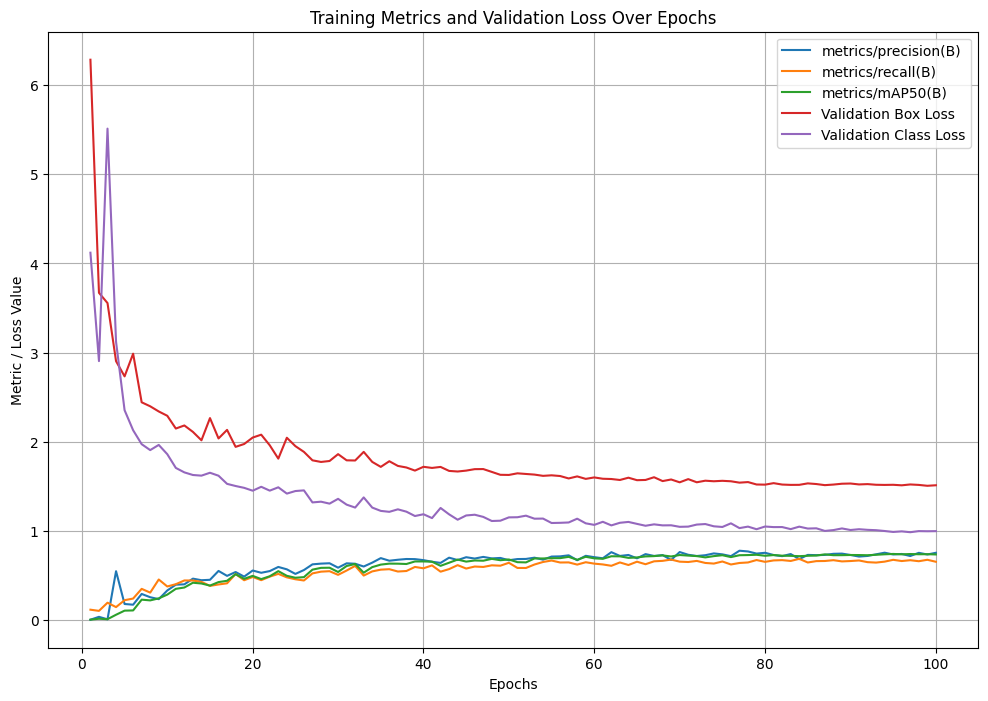

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results from the CSV file
results_df = pd.read_csv('runs/detect/train6222/results.csv')
print(results_df.columns)

# Remove leading spaces from column names
results_df.columns = results_df.columns.str.strip()

# Plot training and validation metrics
plt.figure(figsize=(12, 8))

# Choose the metrics you want to plot (e.g., precision, recall, mAP50)
metrics_to_plot = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)']

for metric in metrics_to_plot:
    plt.plot(results_df['epoch'], results_df[metric], label=metric)

# Plot training and validation losses
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss')

plt.xlabel('Epochs')
plt.ylabel('Metric / Loss Value')
plt.title('Training Metrics and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Actual training
results_actual = model.train(data="data.yaml", epochs=50, imgsz=320)

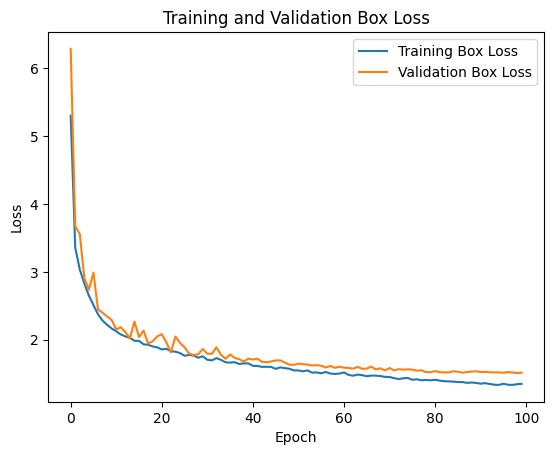

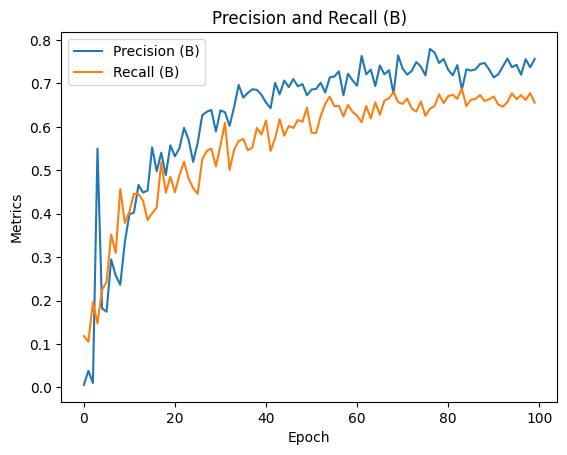

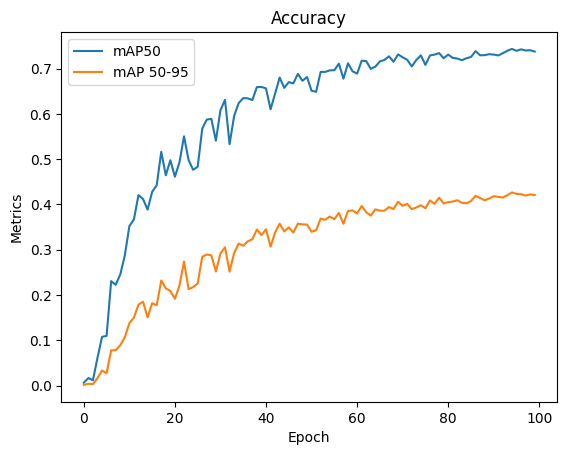

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

results_file = "runs/detect/train6222/results.csv"

plt.figure()
data = pd.read_csv(results_file)

# Stripping whitespaces from column names
data.columns = data.columns.str.strip()

plt.plot(data['train/box_loss'], label='Training Box Loss')
plt.plot(data['val/box_loss'], label='Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Box Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(data['metrics/precision(B)'], label='Precision (B)')
plt.plot(data['metrics/recall(B)'], label='Recall (B)')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision and Recall (B)')
plt.legend()
plt.show()

plt.figure()
plt.plot(data['metrics/mAP50(B)'], label='mAP50')
plt.plot(data['metrics/mAP50-95(B)'], label='mAP 50-95')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Accuracy')
plt.legend()
plt.show()



In [5]:
# generating feature vectors

dataset_path = Path('train')
labels = sorted(dataset_path.glob('labels/*.txt')) # get all labels

yaml_file = 'data.yaml'  
with open(yaml_file, 'r', encoding="utf8") as y:
    data = yaml.safe_load(y)
    classes = {idx: name for idx, name in enumerate(data['names'])}
cls_idx = sorted(classes.keys())


indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`

ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'
    
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio
    
supported_extensions = ['.jpg', '.jpeg', '.png']

# Initialize an empty list to store image file paths
images = []

# Loop through supported extensions and gather image files
for ext in supported_extensions:
    images.extend(sorted((dataset_path / 'images').rglob(f"*{ext}")))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)
        
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

results = {}

weights_path = 'runs/detect/train6222/weights/best.pt' 
model = YOLO(weights_path, task='detect')


for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data="data.yaml",epochs=50, batch=16, imgsz=64)  # include any train arguments
    results[k] = model.metrics  # save output metrics for further analysis

New https://pypi.org/project/ultralytics/8.0.211 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.208  Python-3.9.13 torch-2.1.0+cpu CPU (Intel Core(TM) i7-10510U 1.80GHz)
engine\trainer: task=detect, mode=train, model=runs/detect/train6222/weights/best.pt, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, 

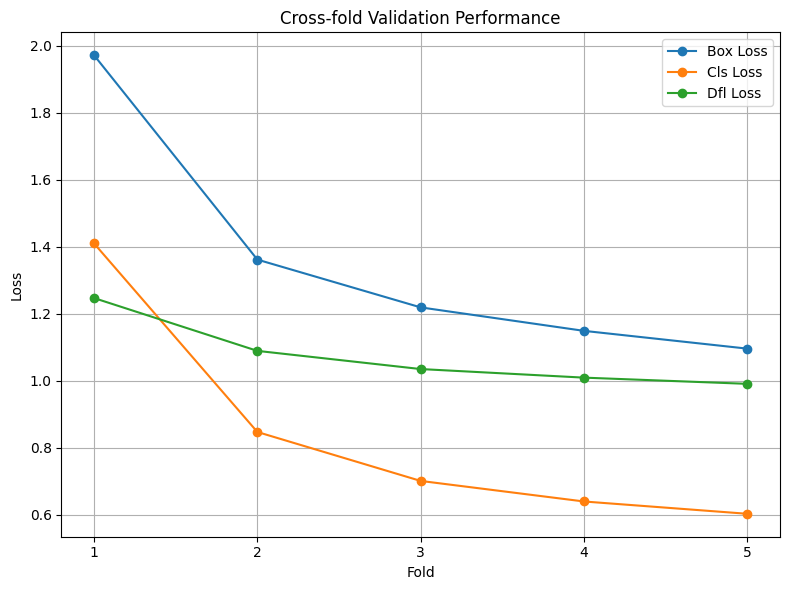

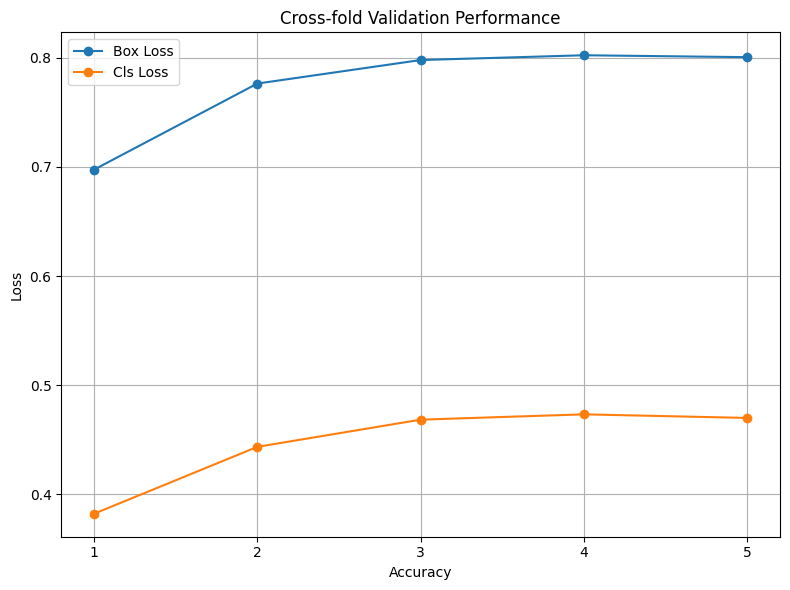

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store metric values
box_loss_values = []
cls_loss_values = []
dfl_loss_values = []
mAP50_values = []
mAP5095_values = []


# Directory pattern for the metric files
directory_pattern = "runs/detect/crossval{fold}/results.csv"

# Number of folds
ksplit = 5

# Extract the metric values for each fold
for k in range(1, ksplit + 1):
    # Construct the file path for the current fold
    file_path = directory_pattern.format(fold=k)
    
    # Load the CSV file for the current fold
    fold_data = pd.read_csv(file_path)
    
    # Extract the metric value of interest from the loaded data
    # Assuming 'desired_metric_column_name' is the column name containing the desired metric
    # Extract the metric values of interest from the loaded data
    box_loss_values.append(fold_data["         train/box_loss"].iloc[0])
    cls_loss_values.append(fold_data["         train/cls_loss"].iloc[0])
    dfl_loss_values.append(fold_data["         train/dfl_loss"].iloc[0])
    mAP50_values.append(fold_data["       metrics/mAP50(B)"].iloc[0])
    mAP5095_values.append(fold_data["    metrics/mAP50-95(B)"].iloc[0])

# Plotting the graph for multiple metrics
fold_indices = list(range(1, ksplit + 1))
plt.figure(figsize=(8, 6))

# Plotting box loss
plt.plot(fold_indices, box_loss_values, marker='o', linestyle='-', label='Box Loss')
# Plotting cls loss
plt.plot(fold_indices, cls_loss_values, marker='o', linestyle='-', label='Cls Loss')
# Plotting dfl loss
plt.plot(fold_indices, dfl_loss_values, marker='o', linestyle='-', label='Dfl Loss')

plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Cross-fold Validation Performance')
plt.xticks(fold_indices)
plt.legend()  # Show legend with metric labels
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

fold_indices = list(range(1, ksplit + 1))
plt.figure(figsize=(8, 6))

# Plotting box loss
plt.plot(fold_indices, mAP50_values, marker='o', linestyle='-', label='Box Loss')
# Plotting cls loss
plt.plot(fold_indices, mAP5095_values, marker='o', linestyle='-', label='Cls Loss')

plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Cross-fold Validation Performance')
plt.xticks(fold_indices)
plt.legend()  # Show legend with metric labels
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
